In [1]:
import pandas as pd
import yfinance as yf

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [3]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple feedforward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\genas\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135.6606 - val_loss: 113.8746 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.4185 - val_loss: 14.6577 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.7107 - val_loss: 9.9095 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.5675 - val_loss: 5.5912 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3325 - val_loss: 2.6680 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3989 - val_loss: 1.1962 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8185 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8250 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3118 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 10/2

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² Score: 0.9722


In [ ]:
import os
from datetime import datetime

# Get the last date
last_index = y_test.tail(1).index[0]

# Convert predictions to Series if needed
if not isinstance(y_pred, pd.Series):
    y_pred = pd.Series(y_pred.flatten(), index=y_test.index)

save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'''
# Create a DataFrame with true, predicted, and timestamp
result_df = pd.DataFrame({
    'Ticker': [tckr] * len(y_test),
    'Actual': y_test.values,
    'Predicted': y_pred.values,
    'Saved': [save_time] * len(y_test),
    'R2 Score': [r2] * len(y_test),
}, index=y_test.index)

'''

# Create a single-row DataFrame for the latest prediction
result_df = pd.DataFrame({
    'Ticker': [tckr],
    'Actual': [y_test.loc[last_index]],
    'Predicted': [y_pred.loc[last_index]],
    'R2 Score': [r2],
    'Saved': [save_time]
}, index=[last_index])

# Reset index and rename as 'Date'
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Date'}, inplace=True)

# Define path
csv_path = 'predictions_log.csv'

# Check if file exists
if os.path.exists(csv_path):
    # Append to the existing file
    result_df.to_csv(csv_path, mode='a', header=False, index=False)
else:
    # Create a new file with headers
    result_df.to_csv(csv_path, mode='w', header=True, index=False)

print(f"✅ Results saved to {csv_path} at {save_time}")

✅ Results saved to predictions_log.csv at 2025-06-03 10:48:23


In [ ]:
y_test

Date
2024-05-01    14.605687
2024-05-02    14.831362
2024-05-03    14.862957
2024-05-06    14.957739
2024-05-07    14.515417
                ...    
2025-05-28    10.520000
2025-05-29    10.505000
2025-05-30    10.385000
2025-06-02    10.330000
2025-06-03    10.300000
Name: Next_High, Length: 273, dtype: float64

In [ ]:
y_pred

Date
2024-05-01    14.770517
2024-05-02    14.590107
2024-05-03    14.795621
2024-05-06    14.949509
2024-05-07    14.852634
                ...    
2025-05-28    10.465234
2025-05-29    10.592732
2025-05-30    10.515322
2025-06-02    10.333292
2025-06-03    10.578253
Length: 273, dtype: float32

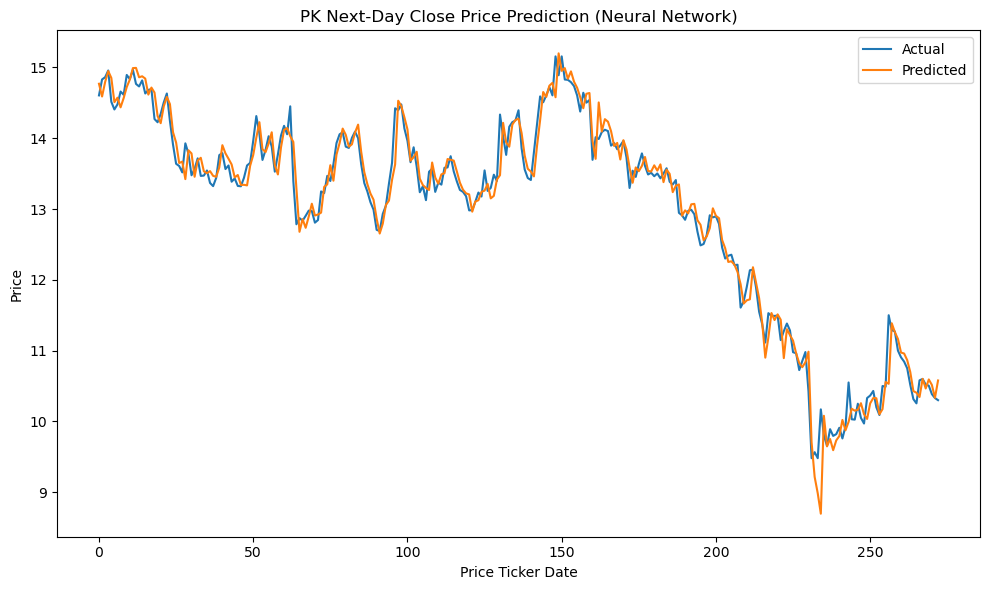

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Price Ticker Date') #('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

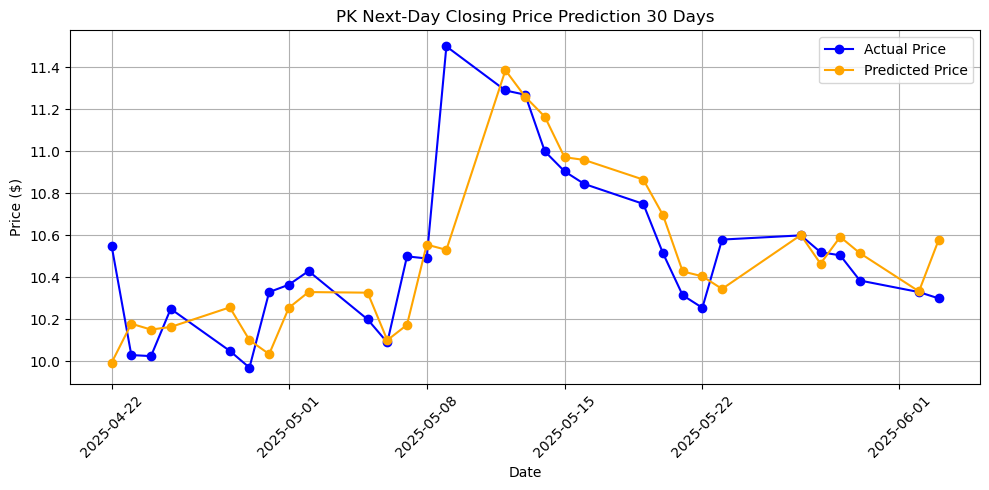

In [ ]:
# Extract last 5 days of test predictions and actuals
last_n = 30
y_test_last = y_test[-last_n:]
y_pred_last = y_pred[-last_n:]

# Extract corresponding dates
if isinstance(y_test.index, pd.DatetimeIndex):
    test_dates = y_test.index[-last_n:]
else:
    # fallback if index is not datetime (e.g., RangeIndex)
    test_dates = pd.date_range(end=pd.Timestamp.today(), periods=last_n)

# Plot last week only
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_last.values, label='Actual Price', marker='o', color='blue')
plt.plot(test_dates, y_pred_last, label='Predicted Price', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{tckr} Next-Day Closing Price Prediction {last_n} Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df

Price,Open,High,Low,Close,Volume,Next_High
Ticker,PK,PK,PK,PK,PK,
Date,,,,,,
2020-01-02,18.614993,18.614993,18.063915,18.071072,2026400,18.146218
2020-01-03,17.892149,18.146218,17.820581,18.114012,2524300,18.013817
2020-01-06,17.942248,18.013817,17.691758,17.706072,1641900,17.634502
2020-01-07,17.591561,17.634502,17.348228,17.412640,2360600,17.498524
2020-01-08,17.391170,17.498524,17.298131,17.477053,2611400,17.527154
...,...,...,...,...,...,...
2025-05-28,10.600000,10.600000,10.380000,10.380000,6398000,10.520000
2025-05-29,10.490000,10.520000,10.325000,10.490000,3195500,10.505000
